In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#pd.set_option('display.max_rows', 200)
#pd.set_option('display.max_columns', 50)

## Examining different reward functions

### Data Processing

In [ ]:
path = os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/plant_area_data.csv'
df = pd.read_csv(path).sort_values(by='timestamp')
df.columns = df.columns.str.replace(' ', '_')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df.head()

In [ ]:
# Get normalized area by subtracting each plants starting area from all area observations
plant_cols = df.columns.difference(['timestamp'])
df_norm = df.copy()
df_norm.loc[:, plant_cols] = df_norm.loc[:, plant_cols].div(df_norm.loc[0, plant_cols]).to_numpy(dtype=float)
df_norm['median_area'] = df_norm.loc[:, plant_cols].median(axis=1)
df_norm['mean_area'] = df_norm.loc[:, plant_cols].mean(axis=1)
df_norm

In [ ]:
# Get change in normalized area at each timestep
delta_df = df_norm.copy()
delta_df.loc[:, plant_cols] = delta_df.loc[:, plant_cols].diff()
delta_df = delta_df.iloc[1:]
# Get median and mean change across all plants for each row
delta_df['median_change'] = delta_df.loc[:, plant_cols].median(axis=1)
delta_df['mean_change'] = delta_df.loc[:, plant_cols].mean(axis=1)
delta_df

In [ ]:
# Get moving window average of past 10 entries for normalized area for all plants
window_size = 10
for col in plant_cols:
    df_norm[f'{col}_window_avg'] = df_norm[col].rolling(window=window_size, min_periods=1, center=True).mean()
df_norm

In [ ]:
# Get areas and window avergaes of area from 1 day prior and compute differences between current area and these values. 
# Note that we drop the first day since it does not have a previous day. 
lagged_plant_cols = {
    f'{col}_lagged': df_norm[col].shift(periods=72)
    for col in plant_cols
}
lagged_window_avg = {
    f'{col}_window_avg_lagged': df_norm[f'{col}_window_avg'].shift(periods=72)
    for col in plant_cols
}
lagged_delta = {
    f'{col}_lagged_delta': df_norm[col] - lagged_plant_cols[f'{col}_lagged'] 
    for col in plant_cols
}
window_avg_lagged_delta = {
    f'{col}_window_avg_lagged_delta': df_norm[col] - lagged_window_avg[f'{col}_window_avg_lagged'] 
    for col in plant_cols
}

df_norm_lag = pd.concat(
    [
        df_norm, 
        pd.DataFrame(lagged_plant_cols), 
        pd.DataFrame(lagged_window_avg),
        pd.DataFrame(lagged_delta),
        pd.DataFrame(window_avg_lagged_delta)
    ], 
    axis=1
).iloc[72:]

df_norm_lag

In [ ]:
# Checking to make sure lag and differences are correct
print(df_norm_lag.iloc[0]['plant_33_(11-13)'])
print(df_norm_lag.iloc[0]['plant_33_(11-13)_lagged'])
print(df_norm_lag.iloc[0]['plant_33_(11-13)_lagged_delta'])
print(df_norm_lag.iloc[0]['plant_33_(11-13)_window_avg_lagged'])
print(df_norm_lag.iloc[0]['plant_33_(11-13)_window_avg_lagged_delta'])

In [10]:
# Get average deltas 
cols_for_lagged_delta = [f'{col}_lagged_delta' for col in plant_cols]
cols_for_window_avg_lagged_delta = [f'{col}_window_avg_lagged_delta' for col in plant_cols]
    
df_norm_lag['mean_lagged_delta'] = df_norm_lag.loc[:, cols_for_lagged_delta].mean(axis=1)
df_norm_lag['mean_window_avg_lagged_delta'] = df_norm_lag.loc[:, cols_for_window_avg_lagged_delta].mean(axis=1)


### Plots

In [ ]:
plt.figure(dpi=500)
plt.ylim(-0.5, 0.5)
plt.plot(delta_df['median_change'], label='median_change_in_area', linewidth=0.5)
plt.plot(delta_df['mean_change'], label='mean_change_in_area', linewidth=0.5)
plt.xlabel('Time Step (10 minutes)')
plt.title("Median and Mean Change in Normalized Area for all plants \n over the entire two week growth period")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=500)
plt.ylim(-.2, .2)
plt.plot(delta_df['median_change'][:71], label='median_change_in_area', linewidth=1)
plt.plot(delta_df['mean_change'][:71], label='mean_change_in_area', linewidth=1)
plt.xlabel('Time Step (10 minutes)')
plt.title("Median and Mean Change in Normalized Area for all plants \n at the start of growth")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=500)
plt.ylim(-.2, .2)
plt.plot(delta_df['median_change'][503:575], label='median_change_in_area', linewidth=1)
plt.plot(delta_df['mean_change'][503:575], label='mean_change_in_area', linewidth=1)
plt.xlabel('Time Step (10 minutes)')
plt.title("Median and Mean Change in Normalized Area for all plants \n after one week")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=500)
plt.ylim(-50, 50)
plt.plot(delta_df['median_change'][1079:], label='median_change_in_area', linewidth=1)
plt.plot(delta_df['mean_change'][1079:], label='mean_change_in_area', linewidth=1)
plt.xlabel('Time Step (10 minutes)')
plt.title("Median and Mean Change in Normalized Area for all plants \n after two weeks")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=500)
example_plants = delta_df.iloc[:71, 1:4]
for plant in example_plants.columns:
    label = ' '.join(plant.split()[:2])
    plt.plot(example_plants.index, example_plants[plant], label=label)

plt.ylim(-.2, .2)
plt.xlabel('Timestep (10 minutes)')
plt.ylabel('Change in \n normalized area (pixels)', rotation=0, labelpad=20)
plt.title("Change in normalized area between timesteps \n for 3 different plants at the start of growth")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=500)
example_plants = delta_df.iloc[503:575, 1:6]
for plant in example_plants.columns:
    label = '_'.join(plant.split('_')[:2])
    plt.plot(example_plants.index, example_plants[plant], label=label)

plt.ylim(-.2, .2)
plt.xlabel('Time Step (10 minutes)')
plt.ylabel('Change in \n normalized area (pixels)', rotation=0, labelpad=20)
plt.title("Change in normalized area for 5 different plants after a week")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=500)
example_plants = delta_df.iloc[1079:, 1:6]
for plant in example_plants.columns:
    label = ' '.join(plant.split()[:2])
    plt.plot(example_plants.index, example_plants[plant], label=label)

plt.ylim(-.3, .3)
plt.xlabel('Time Step (10 minutes)')
plt.ylabel('Change in \n normalized area (pixels)', rotation=0, labelpad=20)
plt.title("Change in normalized area for 5 different plants after two weeks")
plt.legend()
plt.show()

#### Plots for Standup 1/24/24

In [ ]:
plt.figure(dpi=500)
plt.plot(delta_df['mean_change'][72:360], linewidth=1)
for i in range(72, 360, 72):
    plt.axvline(x=i, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axvline(x=72, color='red', linestyle='--', alpha=0.5, linewidth=0.8, label='New Day')
plt.xlabel('Time Step (10 minutes)')
plt.ylabel('Change in \n normalized area (pixels)', rotation=0, labelpad=20)
plt.title("Difference in mean plant normalized area with Δt = 1 timestep \n over four days of growth")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=500)
#plt.ylim(-30, 30)
plt.plot(df_norm_lag['mean_lagged_delta'][0:288], linewidth=1)
for i in range(72, 360, 72):
    plt.axvline(x=i, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axvline(x=72, color='red', linestyle='--', alpha=0.5, linewidth=0.8, label='New Day')
plt.xlabel('Time Step (10 minutes)')
plt.ylabel('Change in \n normalized area (pixels)', rotation=0, labelpad=30)
plt.title("Difference in mean plant normalized area with Δt = 24 hours \n during four days of growth")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=500)
#plt.ylim(-30, 30)
plt.plot(df_norm_lag['mean_window_avg_lagged_delta'][0:288], linewidth=1)
for i in range(72, 360, 72):
    plt.axvline(x=i, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axvline(x=72, color='red', linestyle='--', alpha=0.5, linewidth=0.8, label='New Day')
plt.xlabel('Time Step (10 minutes)')
plt.ylabel('Change in \n normalized area (pixels)', rotation=0, labelpad=40)
plt.title("Difference in current mean plant normalized area and 10 step window average  \n with Δt = 24 hours during four days of growth")
plt.legend()
plt.show()

### Plots comparing reward for experiments with different lengths of darkness. 

##### Data Processing

In [21]:
from pathlib import Path

dir = Path(os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/light-dark-experiments/')
paths = []
for filepath in dir.iterdir():
    if filepath.suffix.lower() == ".csv":
        paths.append(filepath)

In [ ]:
dfs = []
for idx, path in enumerate(paths):
    df = pd.read_csv(path).sort_values(by='timestamp')
    df.columns = df.columns.str.replace(' ', '_')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    plant_cols = df.columns.difference(['timestamp'])
    # Normalize all areas by dividing by first obs
    df.loc[:, plant_cols] = df.loc[:, plant_cols].div(df.loc[0, plant_cols]).to_numpy(dtype=float)
    # Get mean normalized area
    df['mean_normalized_area'] = df.loc[:, plant_cols].mean(axis=1)
    # Get change in mean normalized area for 1 timestep and 24 hr deltas
    df['delta_mean_normalized_area'] = df['mean_normalized_area'].diff()
    df['delta_mean_normalized_area_1_day'] = df['mean_normalized_area'] - df.set_index(
        "timestamp")["mean_normalized_area"].reindex(
        df["timestamp"] - pd.Timedelta(hours=24)
        ).values
    # Get a moving window median of past 10 values for both rewards
    df["delta_mean_normalized_area_moving_average"] = df["delta_mean_normalized_area"].rolling(window=10, min_periods=1).mean()
    df["delta_mean_normalized_area_1_day_moving_average"] = df["delta_mean_normalized_area_1_day"].rolling(window=10, min_periods=1).mean()
    dfs.append(df)

# This one has missing observations at the begining of each day, could be edited but not including for now
dfs.pop(2)

##### Analysis

Note the experiments have differing lengths

In [ ]:
for df in dfs:
    print(df['timestamp'].iloc[-1]-df['timestamp'].iloc[0])

In [ ]:
for df in dfs:
    print(len(df))

##### Plots for delta=1 timestep

In [ ]:
# Full experiment lengths
for df in dfs:
    plt.figure(dpi=500)
    plt.plot(df['delta_mean_normalized_area'], label='Change in mean normalized area', linewidth=0.5)
    plt.plot(df['delta_mean_normalized_area_moving_average'], label='10-step moving average of change in mean normalized area', linewidth=0.5)
    # Start timestamp
    start_time = df["timestamp"].iloc[0]
    # Vertical red lines every 24 hours based on the first timestamp
    for i in range(1, len(df)):
        target_time = start_time + pd.Timedelta(hours=24 * i)
        if target_time in df["timestamp"].values:
            index = df.loc[df["timestamp"] == target_time].index
            plt.axvline(x=index, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        else:
            break
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=0.8, label='New Day')
    plt.ylim(-.1,.1)
    plt.xlabel('Time Step (10 minutes)')
    plt.title("Change in mean normalized area over all plants \n for entire growth period (Δt= 1 timestep)")
    plt.legend()
    plt.show()

In [ ]:
# Second two days (so there is meaningful comparison with 24hr lag)
dfs48 = dfs.copy()
for df in dfs48:
    start_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=24)
    end_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=72)
    df = df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)]
    plt.figure(dpi=500)
    plt.plot(df['delta_mean_normalized_area'], label='Change in mean normalized area', linewidth=0.5)
    plt.plot(df['delta_mean_normalized_area_moving_average'], label='10-step moving average of change in mean normalized area', linewidth=0.5)
    # Vertical red lines every 24 hours
    for i in range(0, len(df)):
        target_time = start_time + pd.Timedelta(hours=24 * i)
        if target_time in df["timestamp"].values:
            index = df.loc[df["timestamp"] == target_time].index
            plt.axvline(x=index, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        else:
            break
    plt.axvline(x=df.loc[df["timestamp"] == start_time].index, color='red', linestyle='--', alpha=0.5, linewidth=0.8, label='New Day')
    plt.ylim(-.1,.1)
    plt.xlabel('Time Step (10 minutes)')
    plt.title("Change in mean normalized area over all plants \n for two days (Δt= 1 timestep)")
    plt.legend()
    plt.show()

##### Plots for delta=24hr

In [ ]:
# Second two days
dfs48 = dfs.copy()
for df in dfs48:
    start_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=24)
    end_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=72)
    df = df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)]
    plt.figure(dpi=500)
    plt.plot(df['delta_mean_normalized_area_1_day'], label='Change in mean normalized area', linewidth=0.5)
    plt.plot(df['delta_mean_normalized_area_1_day_moving_average'], label='10-step moving average of change in mean normalized area', linewidth=0.5)
    # Vertical red lines every 24 hours
    for i in range(1, len(df)):
        target_time = start_time + pd.Timedelta(hours=24 * i)
        if target_time in df["timestamp"].values:
            index = df.loc[df["timestamp"] == target_time].index
            plt.axvline(x=index, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        else:
            break
    plt.axvline(x=df.loc[df["timestamp"] == start_time].index, color='red', linestyle='--', alpha=0.5, linewidth=0.8, label='New Day')
    #plt.ylim(-.1,.1)
    plt.xlabel('Time Step (10 minutes)')
    plt.title("Change in mean normalized area over all plants \n for first two days (Δt=1 day)")
    plt.legend()
    plt.show()

In [ ]:
# Compare reward for different experiments
plt.figure(dpi=500)
for df in dfs:
    plt.plot(df['delta_mean_normalized_area_moving_average'], label='10-step moving average of change in mean normalized area', linewidth=0.5)
plt.ylim(-.05,.05)
plt.xlabel('Time Step (10 minutes)')
plt.title("Change in mean normalized area over all plants \n for whole growth period (Δt= 1 timestep) (10-step moving average)")
#plt.legend()
plt.show()

In [ ]:
# Compare reward for different experiments
plt.figure(dpi=500)
for df in dfs:
    plt.plot(df['delta_mean_normalized_area_1_day_moving_average'], label='10-step moving average of change in mean normalized area', linewidth=0.5)
#plt.ylim(-.1,.1)
plt.xlabel('Time Step (10 minutes)')
plt.title("Change in mean normalized area over all plants \n for whole growth period (Δt= 1 day) (10-step moving average)")
#plt.legend()
plt.show()

In [ ]:
# Compare reward for different experiments
# Second two days (so there is meaningful comparison with 24hr lag)
dfs48 = dfs.copy()
plt.figure(dpi=500)
for df in dfs48:
    start_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=24)
    end_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=72)
    df = df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)]
    #plt.plot(df['delta_mean_normalized_area'], label='Change in mean normalized area', linewidth=0.5)
    plt.plot(df['delta_mean_normalized_area'], label='10-step moving average of change in mean normalized area', linewidth=0.5)
#plt.ylim(-.1,.1)
plt.xlabel('Time Step (10 minutes)')
plt.title("Change in mean normalized area over all plants \n for two days (Δt= 1 timestep)")
#plt.legend()
plt.show()

In [ ]:
# Compare reward for different experiments
# Second two days (so there is meaningful comparison with 24hr lag)
dfs48 = dfs.copy()
plt.figure(dpi=500)
for df in dfs48:
    start_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=24)
    end_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=72)
    df = df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)]
    #plt.plot(df['delta_mean_normalized_area'], label='Change in mean normalized area', linewidth=0.5)
    plt.plot(df['delta_mean_normalized_area_1_day'], label='10-step moving average of change in mean normalized area', linewidth=0.5)
#plt.ylim(-.1,.1)
plt.xlabel('Time Step (10 minutes)')
plt.title("Change in mean normalized area over all plants \n for two days (Δt= 1 day)")
#plt.legend()
plt.show()

In [ ]:
# Compare reward for different experiments
# Second two days (so there is meaningful comparison with 24hr lag)
dfs48 = dfs.copy()
plt.figure(dpi=500)
for df in dfs48:
    start_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=24)
    end_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=72)
    df = df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)]
    #plt.plot(df['delta_mean_normalized_area'], label='Change in mean normalized area', linewidth=0.5)
    plt.plot(df['delta_mean_normalized_area_moving_average'], label='10-step moving average of change in mean normalized area', linewidth=0.5)
plt.ylim(-.05,.05)
plt.xlabel('Time Step (10 minutes)')
plt.title("Change in mean normalized area over all plants \n for two days. (Δt= 1 timestep) (10-step moving average)")
#plt.legend()
plt.show()

In [ ]:
# Compare reward for different experiments
# Second two days (so there is meaningful comparison with 24hr lag)
dfs48 = dfs.copy()
plt.figure(dpi=500)
for df in dfs48:
    start_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=24)
    end_time = df["timestamp"].iloc[0] + pd.Timedelta(hours=72)
    df = df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)]
    #plt.plot(df['delta_mean_normalized_area'], label='Change in mean normalized area', linewidth=0.5)
    plt.plot(df['delta_mean_normalized_area_1_day_moving_average'], label='10-step moving average of change in mean normalized area', linewidth=0.5)
#plt.ylim(-.1,.1)
plt.xlabel('Time Step (10 minutes)')
plt.title("Change in mean normalized area over all plants \n for two days (Δt= 1 day) (10-step moving average)")
#plt.legend()
plt.show()

#### Plots for Jan 31 meeting

Testing the following rewards:

1. (current_area - 1 timestep prior area) / 1 timestep prior area

2. (current_area - 24hr_prior_area) / 24hr_prior_area	

3. (current_moving_average - 24hr_prior_area_moving_average) / 24hr_prior_area_moving_average

##### Data processing

In [25]:
def process_data(path):
    df = pd.read_csv(path).sort_values(by='timestamp')
    df.columns = df.columns.str.replace(' ', '_')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df = df.dropna()
    plant_cols = df.columns.difference(['timestamp'])
    df['total_area'] = df[plant_cols].sum(axis=1)
    # Raw difference between timesteps
    df['raw_change_1_step'] = df['total_area'].diff()
    # (current_area - 1 timestep prior area) / 1 timestep prior area
    df['pct_change_1_step'] = df['total_area'].pct_change()
    # (current_area - 24hr_prior_area) / 24hr_prior_area
    df['pct_change_1_day'] = df['total_area'].pct_change(periods=72)
    # Pairwise pct change in area - 1 day
    df['pairwise_pct_change_1_step'] = df[plant_cols].pct_change().mean(axis=1)
    # Pairwise pct change in area - 24 hr
    df['pairwise_pct_change_1_day'] = df[plant_cols].pct_change(periods=72).mean(axis=1)
    # Moving average of total area 
    df['total_area_moving_avg'] = df['total_area'].rolling(window=10, min_periods=1).mean()
    # (current_moving_average - 24hr_prior_area_moving_average) / 24hr_prior_area_moving_average
    df['pct_change_1_day_moving_avg'] = df['total_area_moving_avg'].pct_change(periods=72)
    
    return df

In [46]:
path = os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/plant_area_data.csv'
df = process_data(path)

In [60]:
pd.set_option('display.max_rows', 100)  # Show all rows
df['plant_44_(WT)']

0         423.0
1         437.0
2         427.0
3         427.0
4         439.0
         ...   
1147    10764.0
1148    10789.0
1149    10789.0
1150    10835.0
1151    10835.0
Name: plant_44_(WT), Length: 1152, dtype: float64

In [64]:
~(df == 0).any()

timestamp                      -1
plant_1_(4-12-7)               -1
plant_2_(4-12-7)               -1
plant_3_(4-12-7)               -1
plant_4_(4-12-7)               -1
plant_5_(4-12-7)               -1
plant_6_(4-12-7)              -14
plant_7_(4-12-7)               -1
plant_8_(4-12-7)               -1
plant_9_(10-6)                 -1
plant_10_(10-6)                -1
plant_11_(10-6)                -1
plant_12_(10-6)               -14
plant_13_(10-6)                -1
plant_14_(10-6)                -1
plant_15_(10-6)                -1
plant_16_(10-6)                -1
plant_17_(12-2)                -1
plant_18_(12-2)                -1
plant_19_(12-2)                -1
plant_20_(12-2)                -1
plant_21_(12-2)               -15
plant_22_(12-2)                -1
plant_23_(12-2)                -1
plant_24_(12-2)                -1
plant_25_(9-11)                -1
plant_26_(9-11)                -2
plant_27_(9-11)                -1
plant_28_(9-11)                -1
plant_29_(9-11

In [27]:
def plot_rew(df, col, start=0, stop=None, title = None, ylabel='% change \n (pixels)'):
    if stop is None:
        stop = len(df)
    plt.figure(dpi=500)
    plt.plot(df[col][start:stop], linewidth=0.5)
    # Vertical red lines every 24 hours
    start_time = df['timestamp'][start]
    stop_time = df['timestamp'][stop-1]
    for i in range(0, len(df)):
        target_time = start_time + pd.Timedelta(hours=24 * i)
        if target_time <= stop_time:
            index = df.loc[df["timestamp"] == target_time].index
            plt.axvline(x=index, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
        else:
            break
    plt.axhline(y=0, color='red', linewidth=1, alpha=0.5)
    plt.axvline(x=df.loc[df["timestamp"] == start_time].index, color='red', linestyle='--', alpha=1, linewidth=0.8, label='New Day')
    plt.xlabel('Timestep (10 minutes)')
    plt.ylabel(ylabel, rotation=0, labelpad=30)
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()

#### Using pct_change in area over all plants does reduce variance a bit

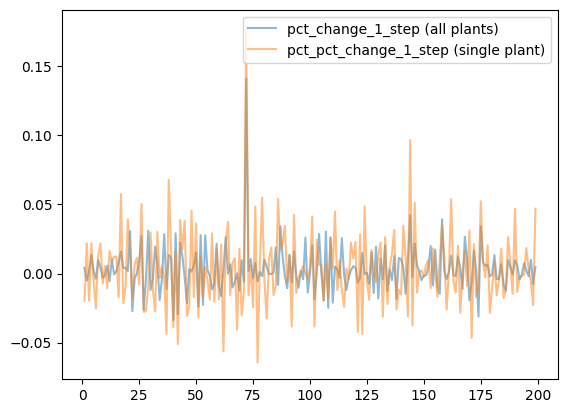

In [ ]:
all = df['pct_change_1_step']
indv = df['plant_1_(4-12-7)'].pct_change()

plt.figure()
plt.plot(all[:200], label="pct_change_1_step (all plants)", alpha=0.5)
plt.plot(indv[:200], label="pct_pct_change_1_step (single plant)", alpha=0.5)
plt.legend()
plt.show()

#### Note that pairwise change does not reduce variance in change in area

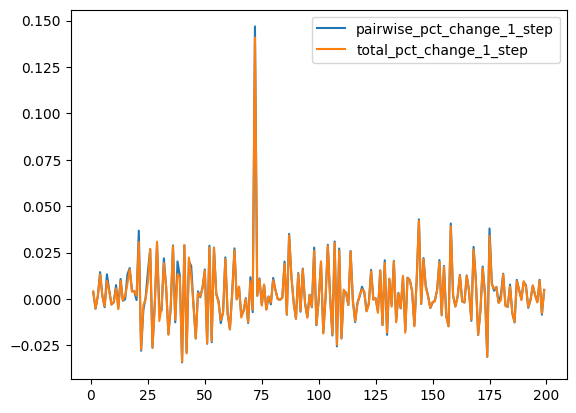

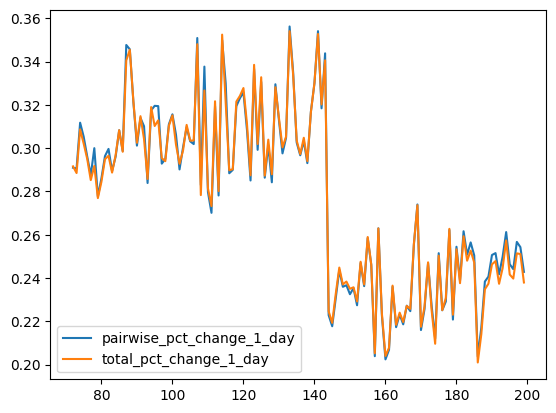

In [38]:
# All plants
p = df['pairwise_pct_change_1_step']
t = df['pct_change_1_step']

plt.figure()
plt.plot(p[:200], label="pairwise_pct_change_1_step")
plt.plot(t[:200], label="total_pct_change_1_step")
plt.legend()
plt.show()

p = df['pairwise_pct_change_1_day']
t = df['pct_change_1_day']

plt.figure()
plt.plot(p[:200], label="pairwise_pct_change_1_day")
plt.plot(t[:200], label="total_pct_change_1_day")
plt.legend()
plt.show()

In [ ]:
# First let's just plot the total area
plot_rew(df, 'total_area', title="Total plant area over entire growth period", ylabel='Total area \n (pixels)')
plot_rew(df, 'total_area', start=648, stop=864, title="Total plant area over 3 days \n in the middle of growth period", ylabel='Total area \n (pixels)')
plot_rew(df, 'total_area', start=648, stop=720, title="Total plant area over 1 day \n in the middle of growth period", ylabel='Total area \n (pixels)')

In [ ]:
# Plots over entire growth period
plot_rew(df, 'raw_change_1_step', title="Raw change in total plant area (Δt= 1 timestep) \n over entire growth period")
plot_rew(df, 'pct_change_1_step', title="Percent change in total plant area (Δt= 1 timestep) \n over entire growth period")
plot_rew(df, 'pct_change_1_day', title="Percent change in total plant area (Δt= 24 hr) \n over entire growth period")
plot_rew(df, 'pct_change_1_day_moving_avg', title="Percent change in 10-step moving average of total plant area \n (Δt= 24 hr) over entire growth period")

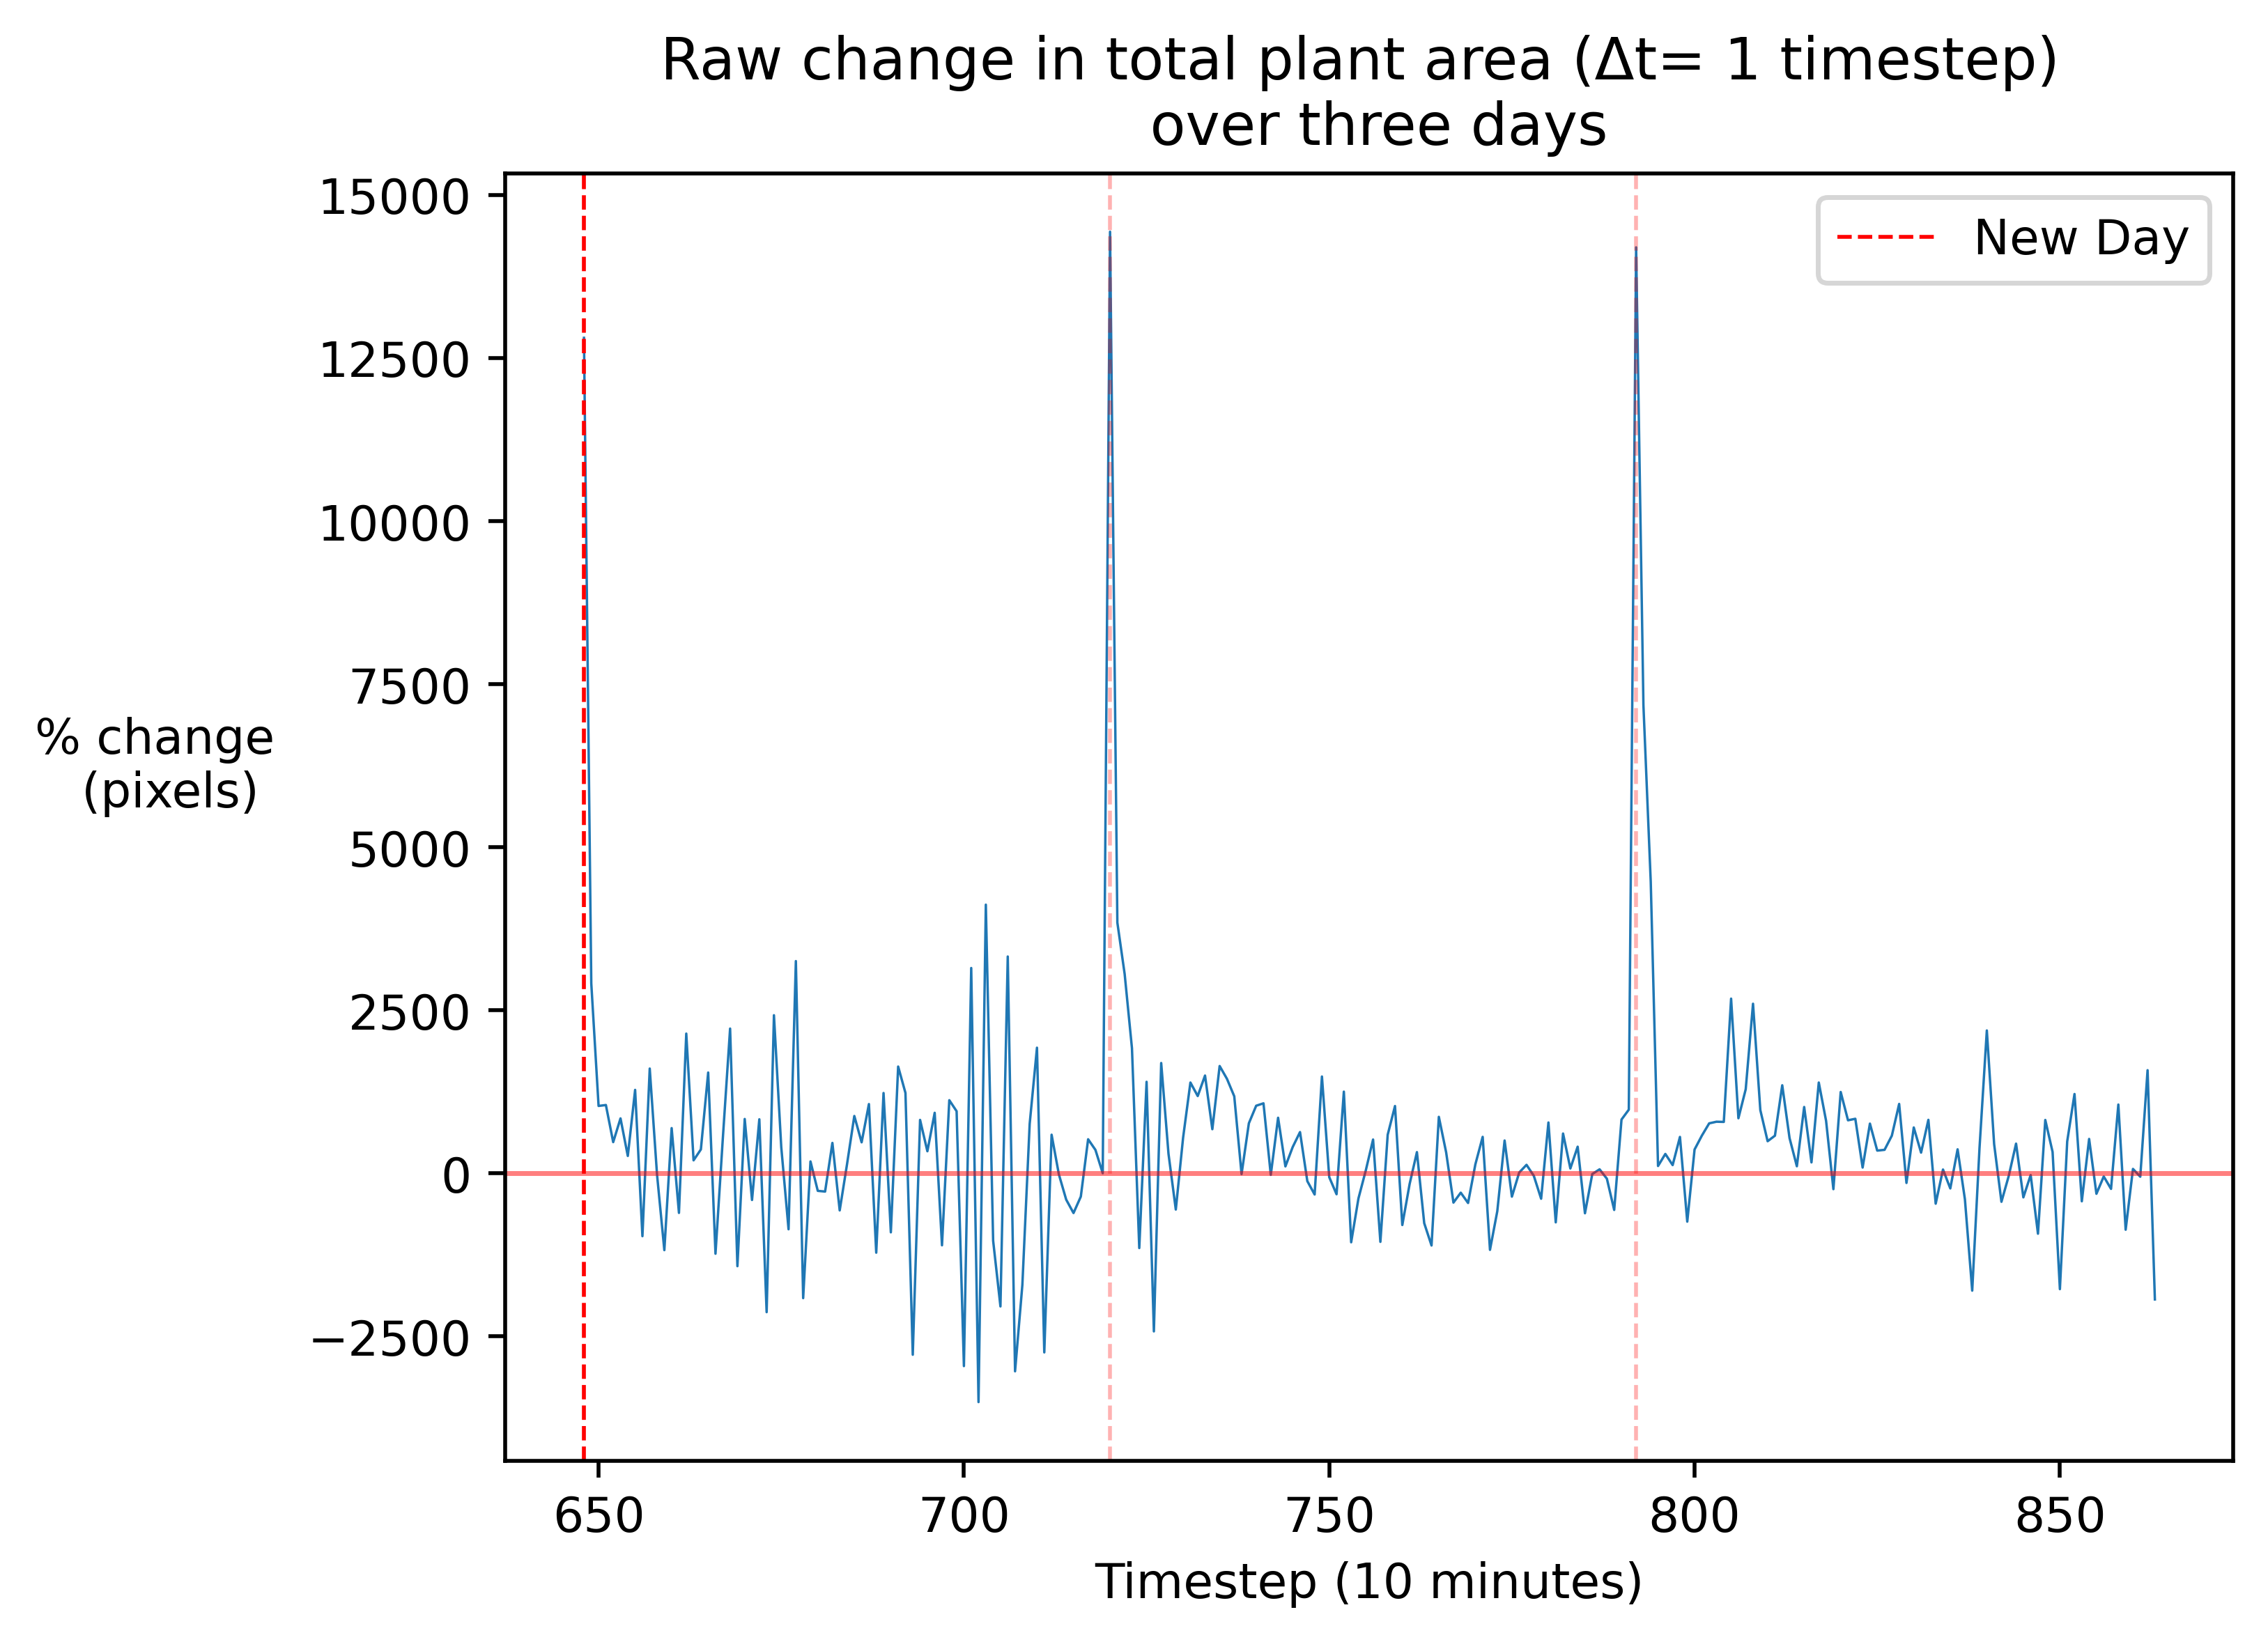

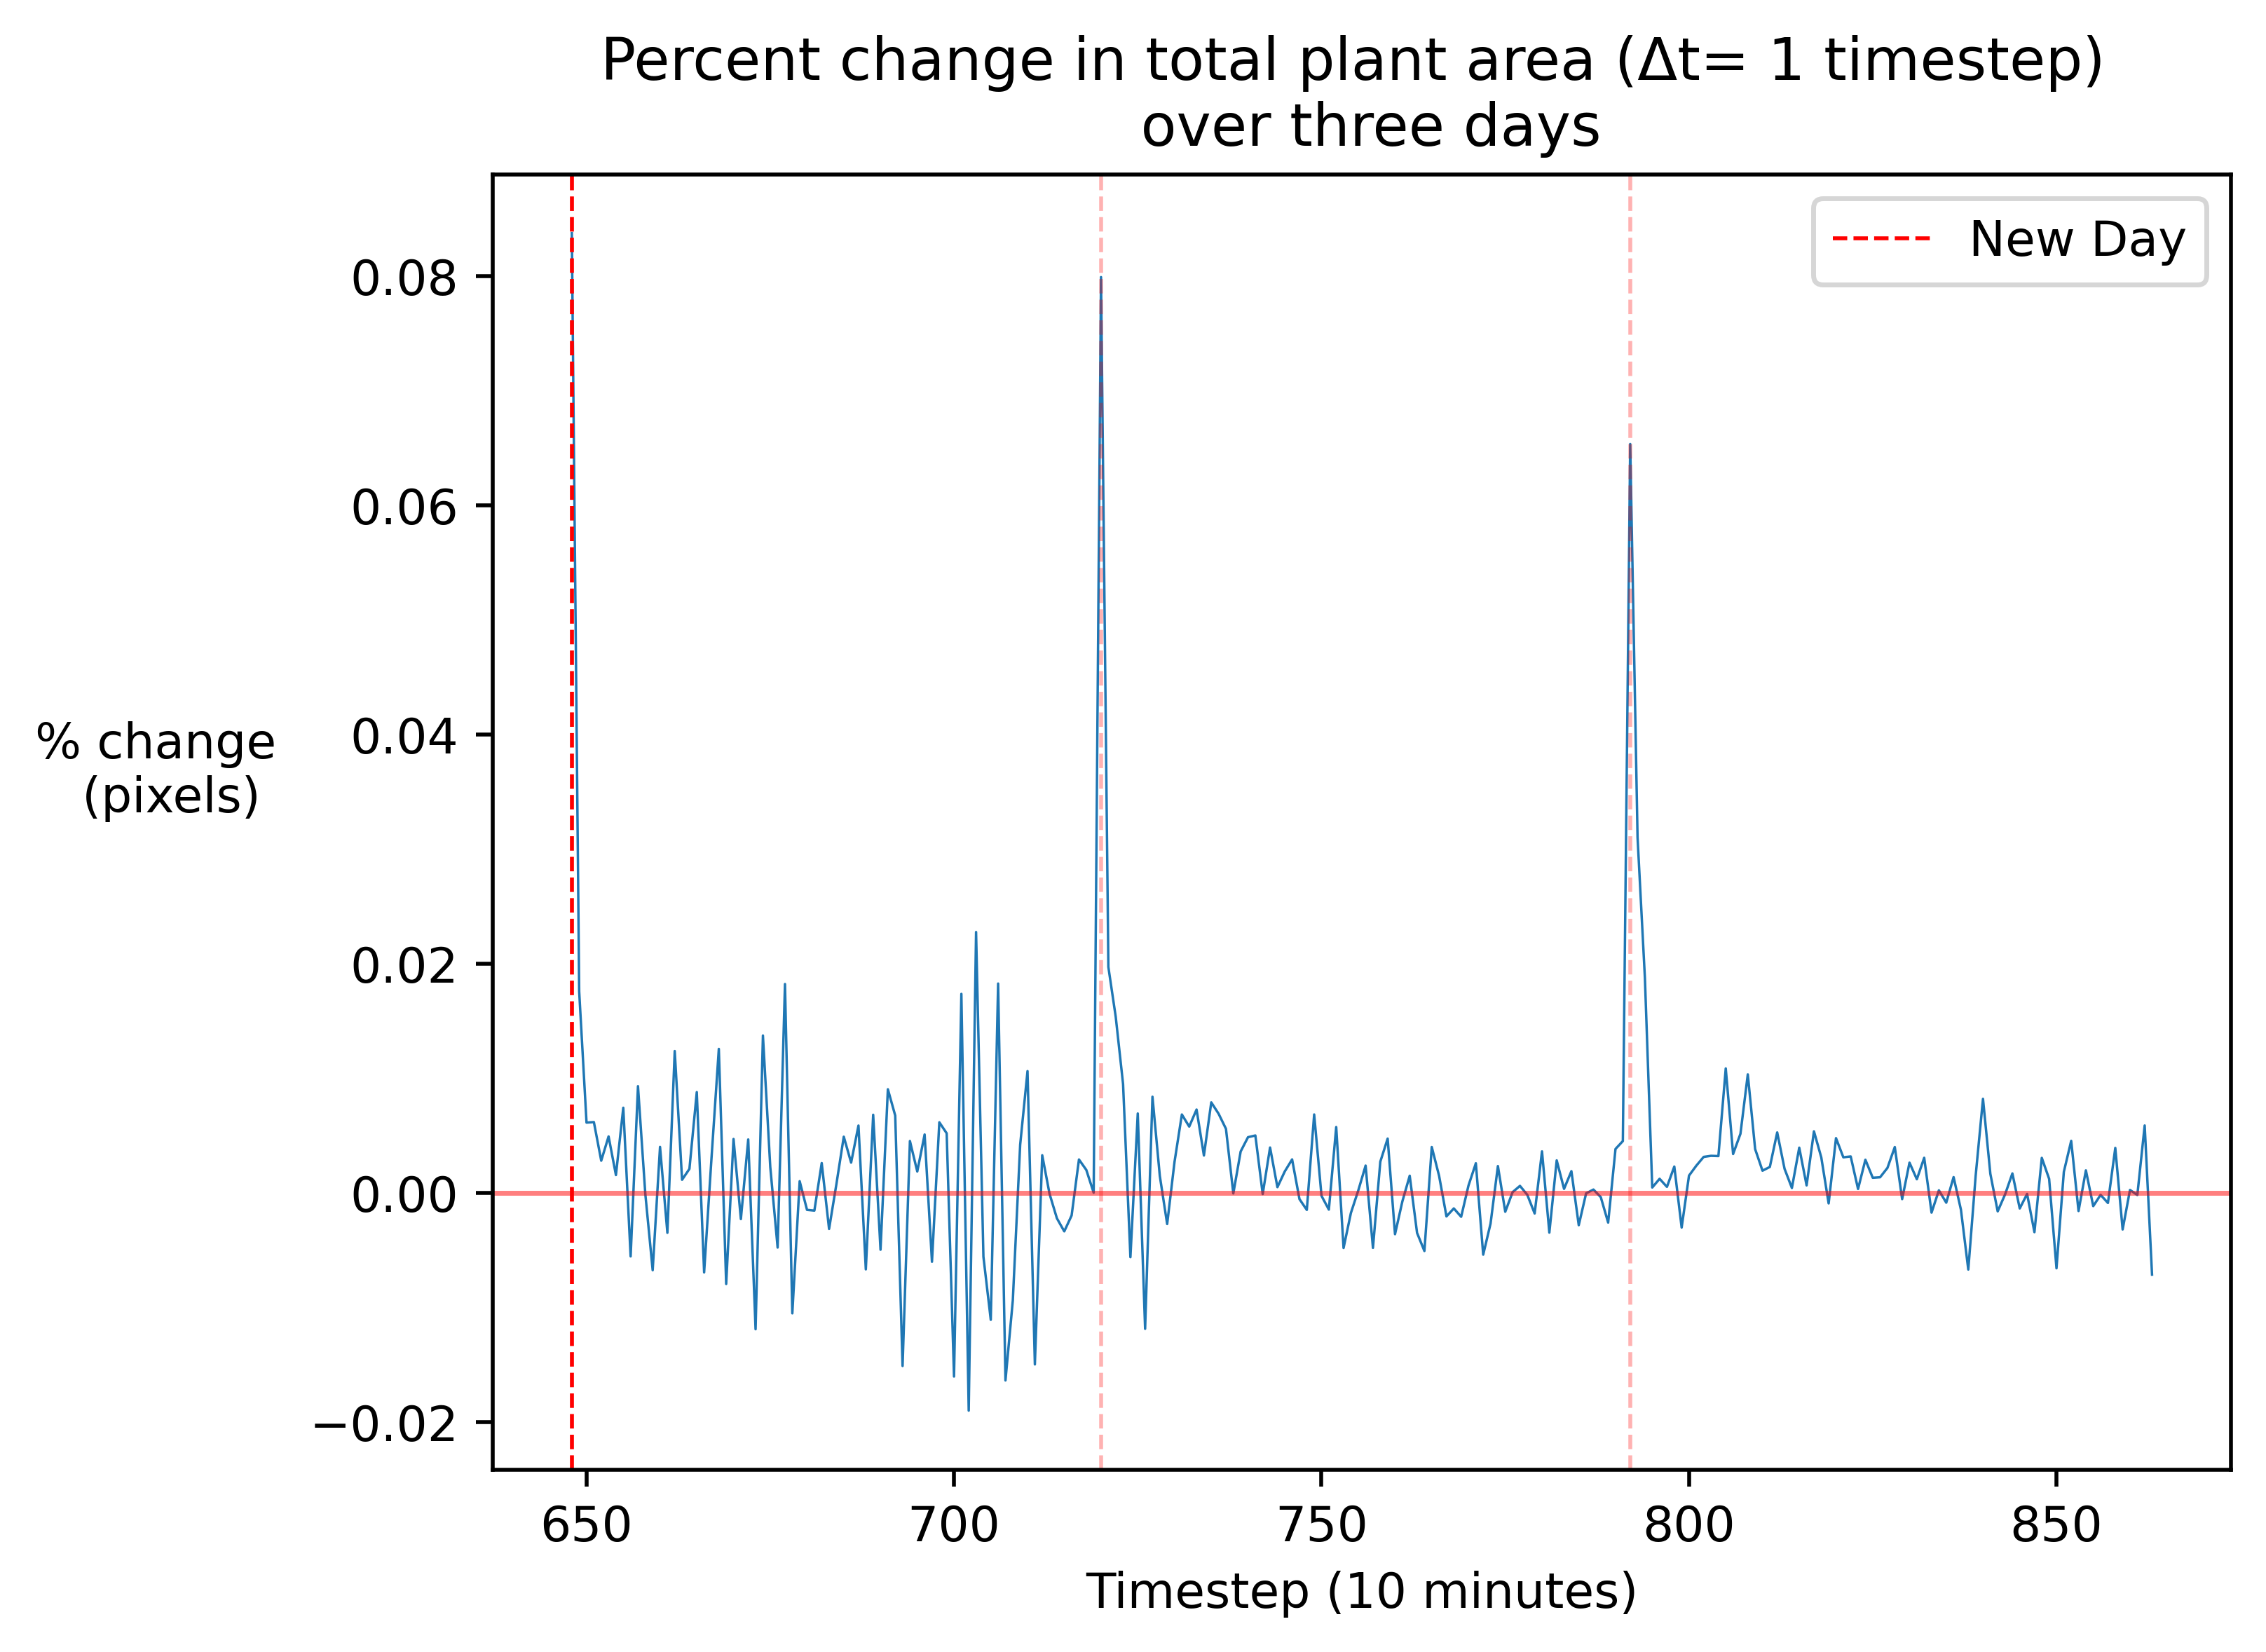

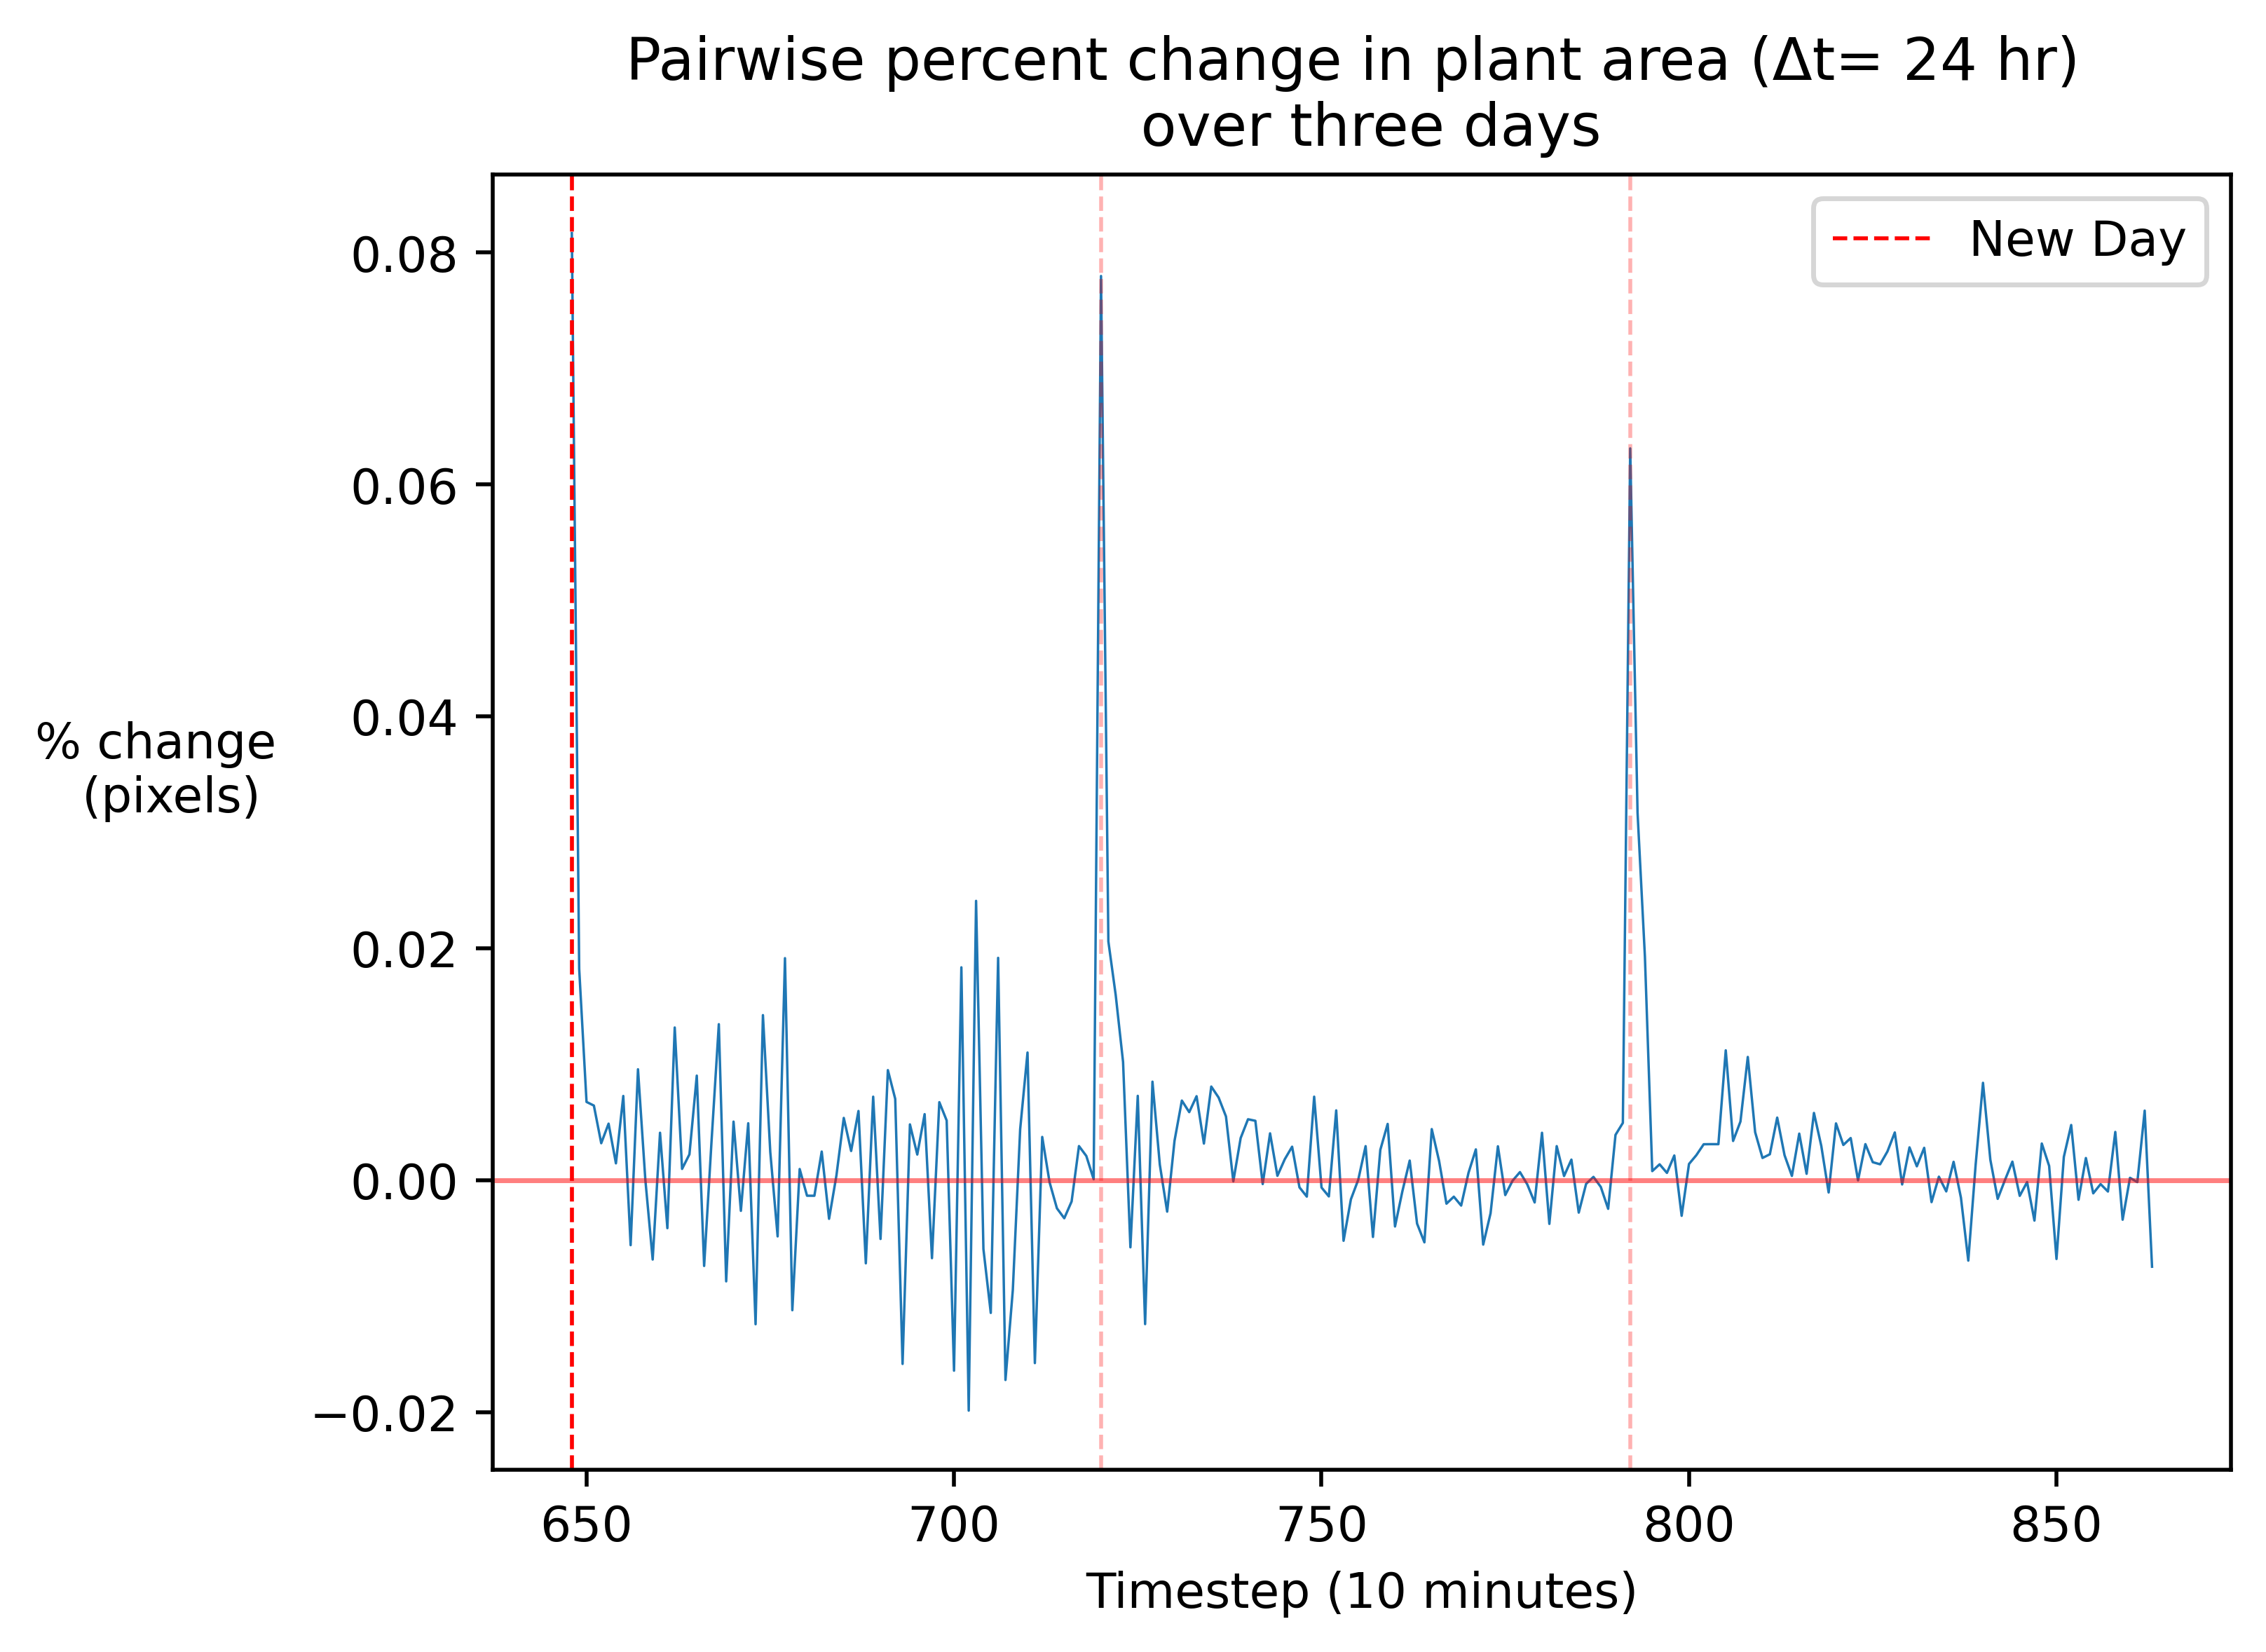

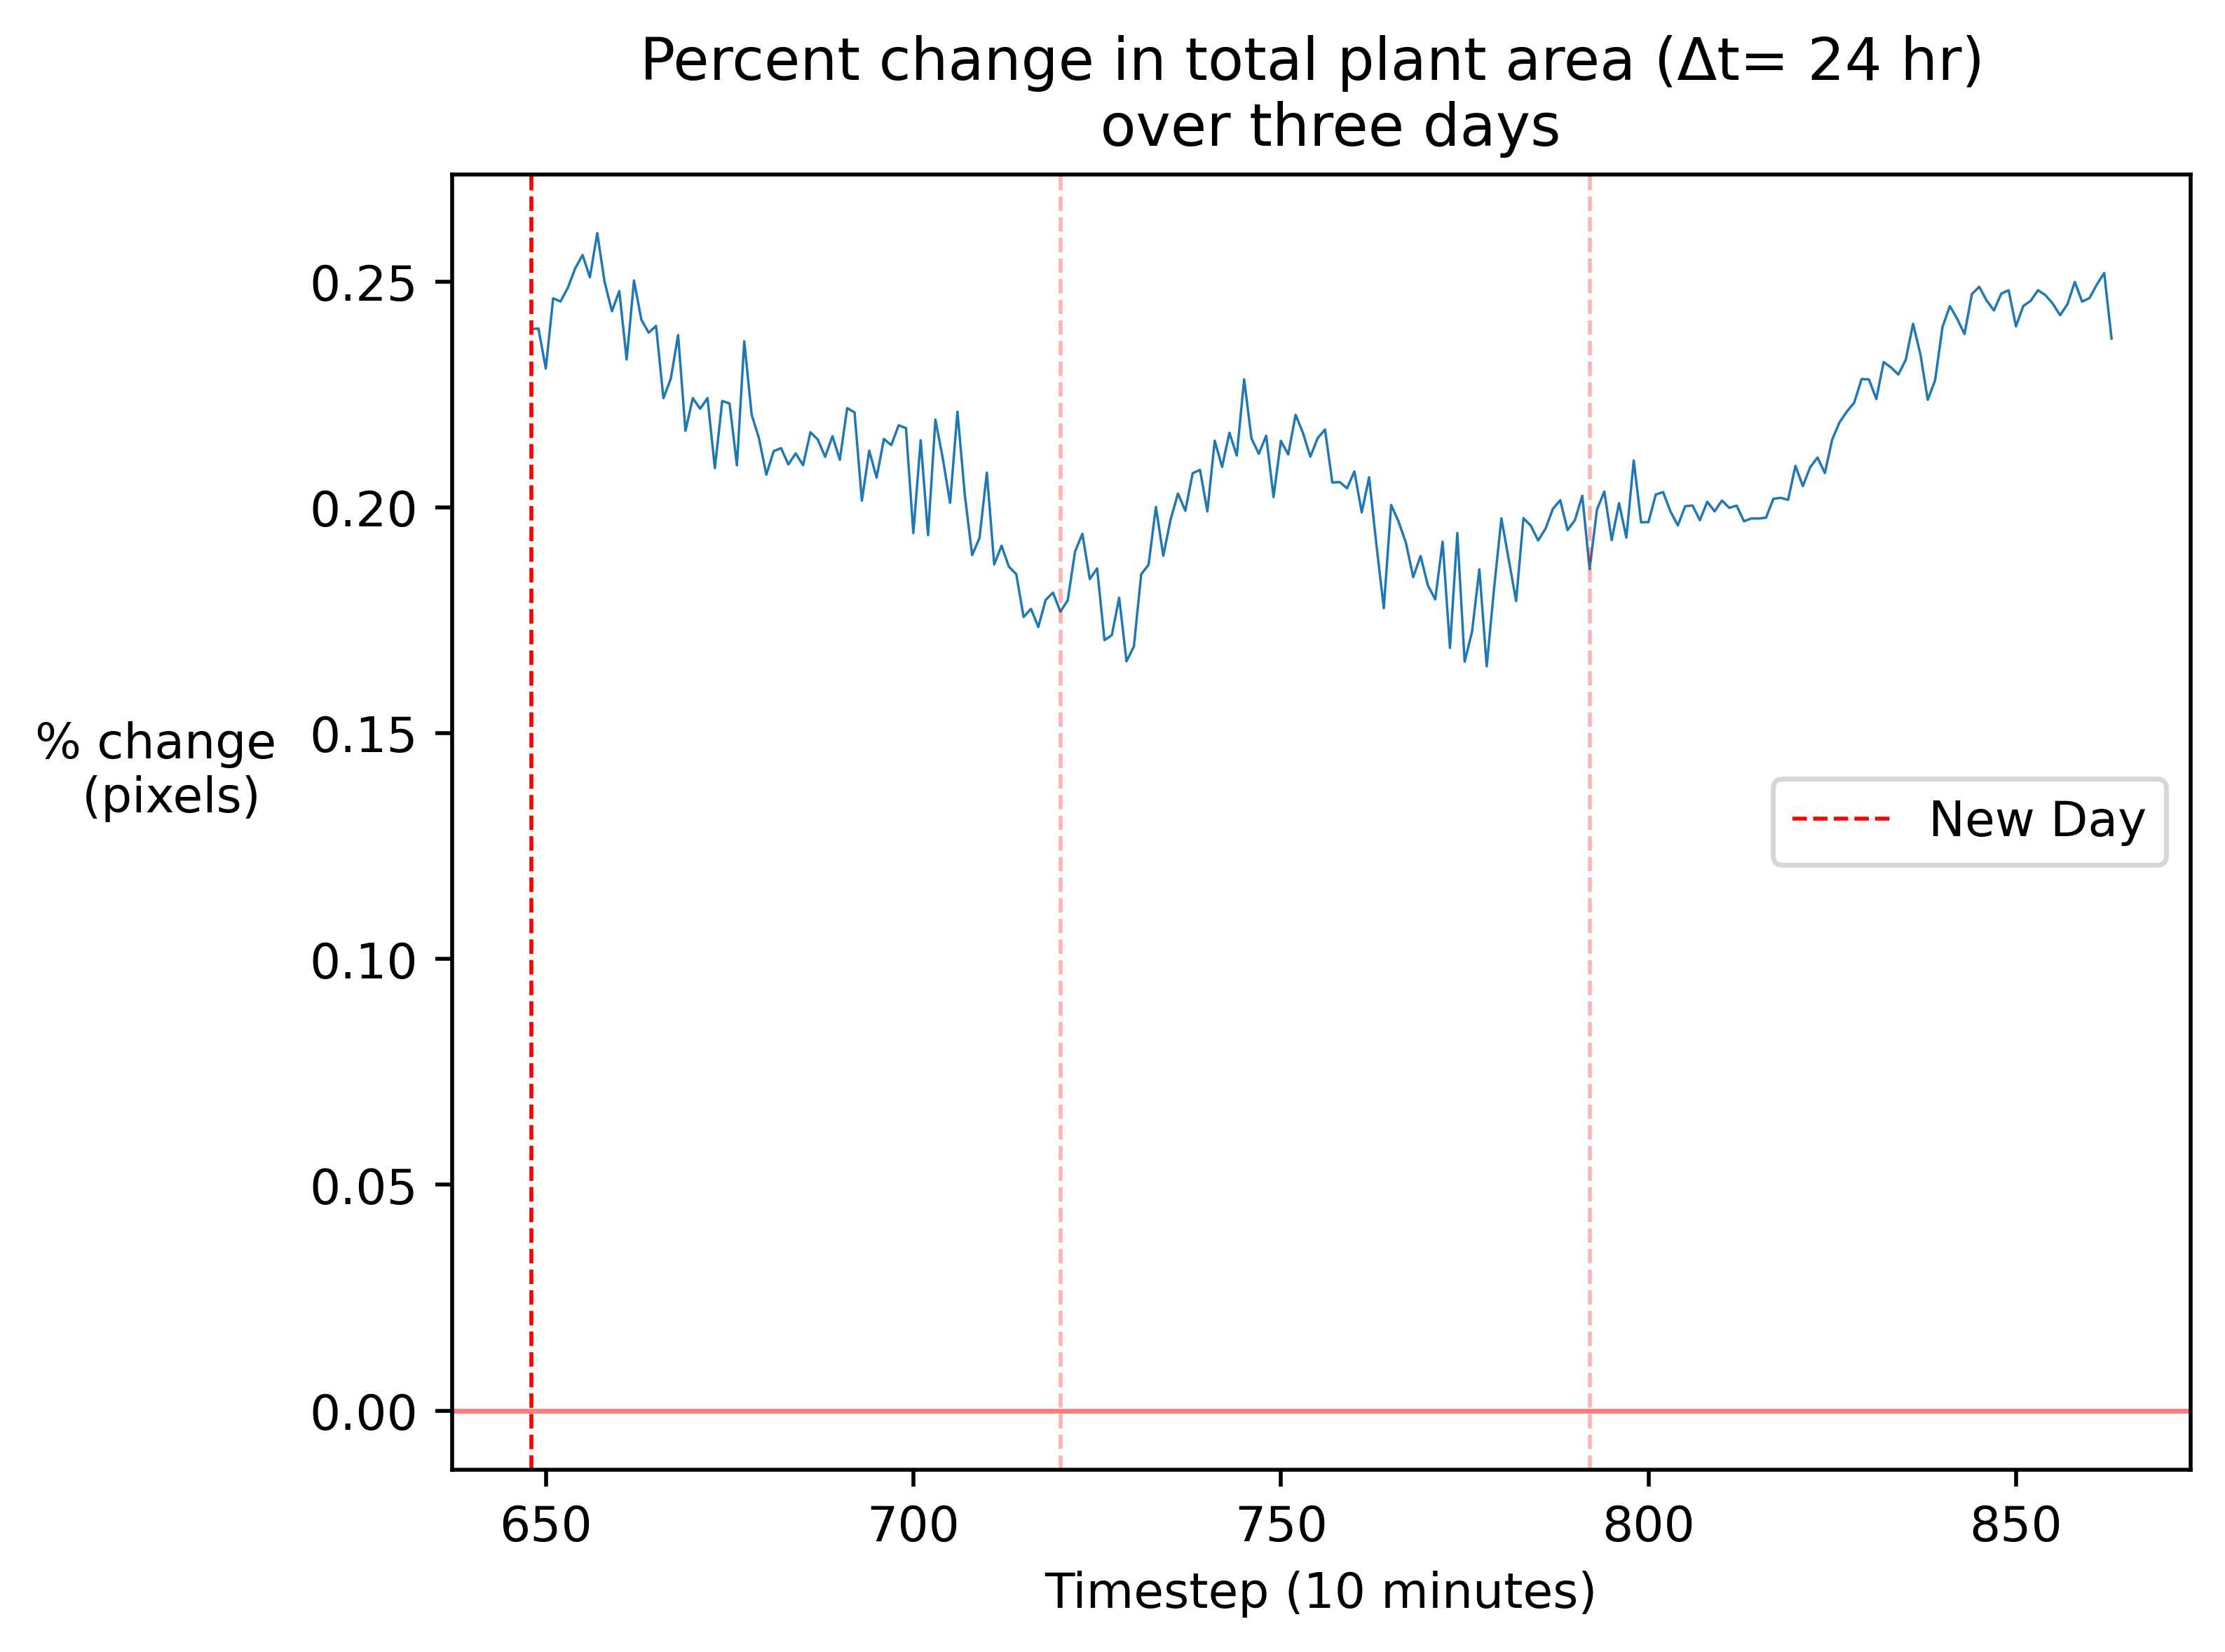

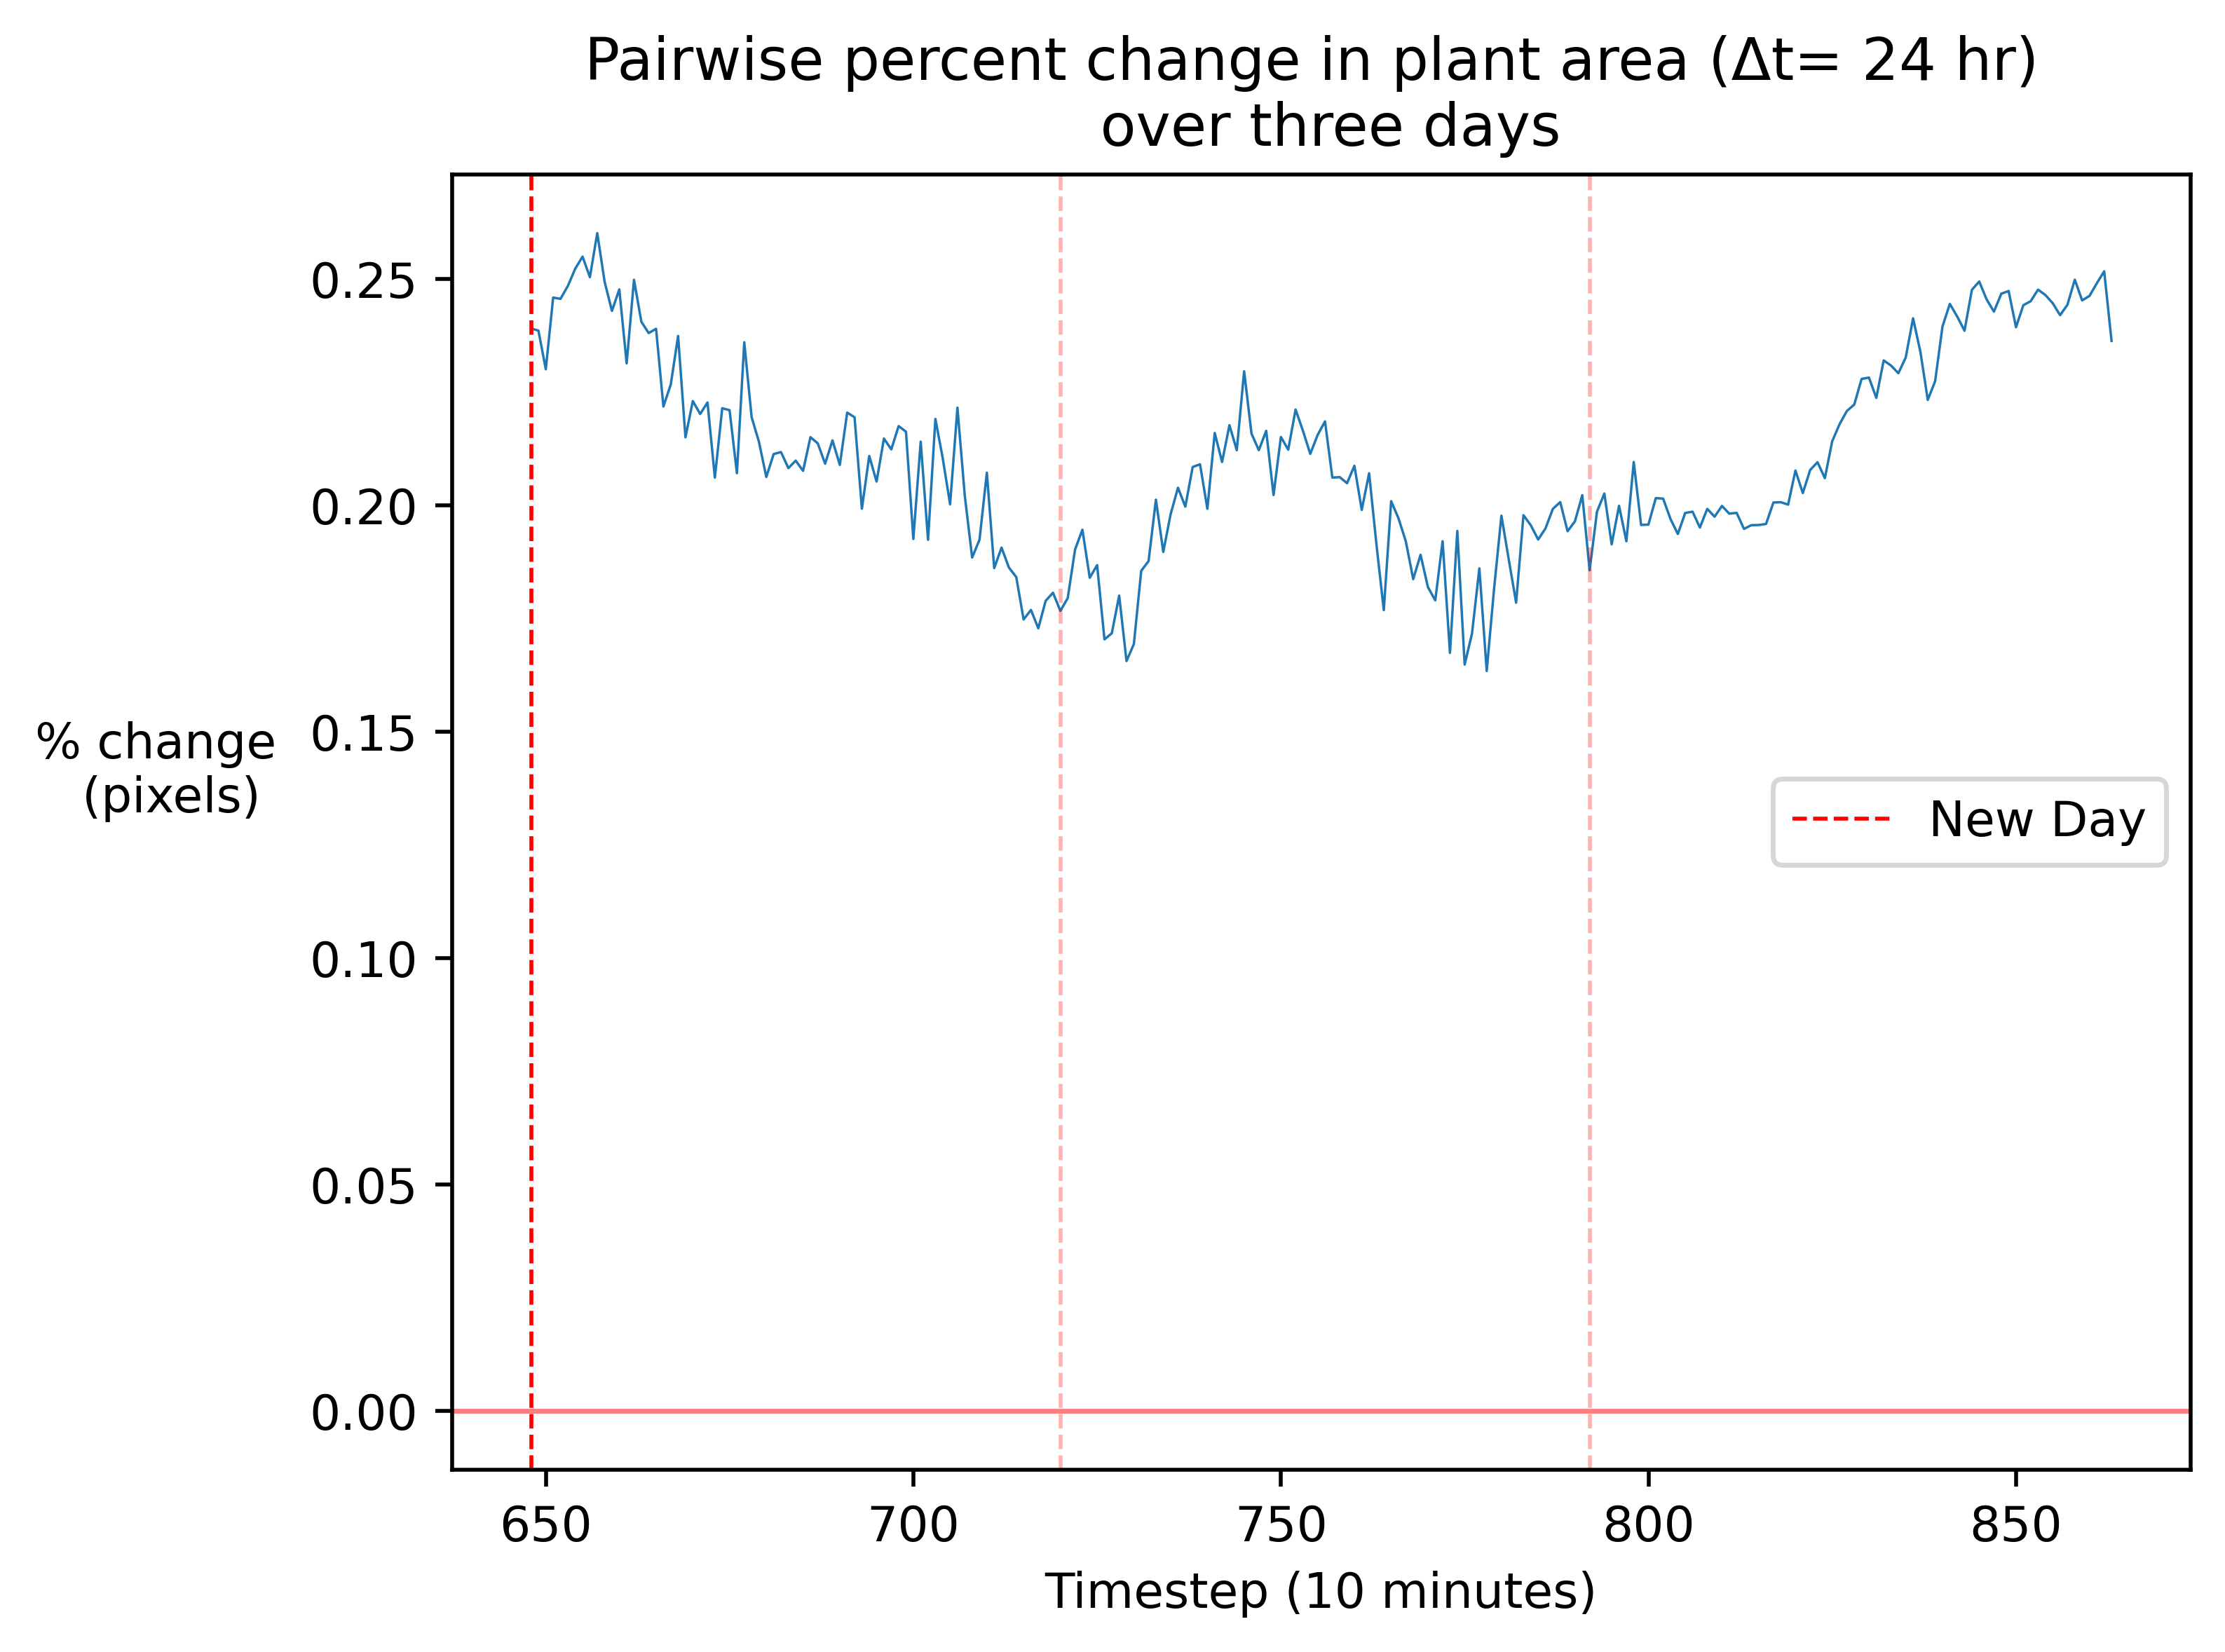

In [28]:
# Plots over 3 days
plot_rew(df, 'raw_change_1_step', start=648, stop=864, title="Raw change in total plant area (Δt= 1 timestep) \n over three days")
plot_rew(df, 'pct_change_1_step', start=648, stop=864, title="Percent change in total plant area (Δt= 1 timestep) \n over three days")
plot_rew(df, 'pairwise_pct_change_1_step', start=648, stop=864, title="Pairwise percent change in plant area (Δt= 24 hr) \n over three days")
plot_rew(df, 'pct_change_1_day', start=648, stop=864, title="Percent change in total plant area (Δt= 24 hr) \n over three days")
plot_rew(df, 'pairwise_pct_change_1_day', start=648, stop=864, title="Pairwise percent change in plant area (Δt= 24 hr) \n over three days")


In [549]:
def plot_rew_subplot(df, cols, suptitle, titles, start=0, stop=None, ylabel='% change \n (pixels)'):
    if stop is None:
        stop = len(df)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=500, sharex=True)
    fig.suptitle(suptitle, fontsize=14)
    
    start_time = df['timestamp'][start]
    stop_time = df['timestamp'][stop-1]
    
    for i, col in enumerate(cols):
        ax = axes[i]
        ax.plot(df[col][start:stop], linewidth=0.5)
        
        # Vertical red lines every 24 hours
        for j in range(0, len(df)):
            target_time = start_time + pd.Timedelta(hours=24 * j)
            if target_time <= stop_time:
                index = df.loc[df["timestamp"] == target_time].index
                ax.axvline(x=index, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
            else:
                break
        ax.axvline(x=df.loc[df["timestamp"] == start_time].index, color='red', linestyle='--', alpha=1, linewidth=0.8, label='New Day')
        ax.set_title(titles[i], fontsize=10)
        ax.set_ylabel(ylabel if i == 0 else "", rotation=0, fontsize=12)
        ax.yaxis.set_label_coords(-0.25, 0.5)

    fig.text(0.5, -0.05, 'Timestep (10 minutes)', ha='center', fontsize=12)
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', fontsize=16)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()

In [ ]:
# Entire growth period
plot_rew_subplot(
    df, 
    ['pct_change_1_step', 
     'pct_change_1_day', 
     'pct_change_1_day_moving_avg'], 
    "Different reward functions over entire growth period",
    ["Percent change in total \n plant area (Δt= 1 timestep)",
     "Percent change in total \n plant area (Δt= 24 hr)",
     "Percent change in 10-step moving average \n of total plant area (Δt= 24 hr)"])

In [ ]:
# 3 Days
plot_rew_subplot(
    df,
    ['pct_change_1_step', 
     'pct_change_1_day', 
     'pct_change_1_day_moving_avg'], 
    "Different reward functions over 3 days in the middle of growth period",
    ["Percent change in total \n plant area (Δt= 1 timestep)",
     "Percent change in total \n plant area (Δt= 24 hr)",
     "Percent change in 10-step moving average \n of total plant area (Δt= 24 hr)"],
    start=648, 
    stop=864,
    )

#### Plotting different reward functions for day/night experiments

In [ ]:
from pathlib import Path

dir = Path(os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/light-dark-experiments/')
paths = []
for filepath in dir.iterdir():
    if filepath.suffix.lower() == ".csv":
        paths.append(filepath)

dfs = []
for path in paths:
    dfs.append(process_data(path))
# This one has missing observations at the begining of each day, could be edited but not including for now
dfs.pop(2)
dfs[0]

In [ ]:
data = []
cols = ["pct_change_1_step", "pct_change_1_day", "pct_change_1_day_moving_avg", "raw_change_1_step"]
for i, df in enumerate(dfs):
    returns = {col: df[col].sum() for col in cols}
    total_change = df["total_area"].iloc[-1] - df["total_area"].iloc[0]
    data.append((i, total_change, returns))

# Sort by total change in area
data_sorted = sorted(data, key=lambda x: x[1])

# Get labels for dfs
labels = [f"DF {i+1}" for i, _, _ in data_sorted]

# Not including raw change here since if dwarfs other values
rets = {col: np.array([vals[col] for _, _, vals in data_sorted]) for col in cols if col != "raw_change_1_step"}

'''
pct_change_1_step = [vals["pct_change_1_step"] for _, _, vals in data_sorted]
pct_change_1_day = [vals["pct_change_1_day"] for _, _, vals in data_sorted]
pct_change_1_day_moving_avg = [vals["pct_change_1_day_moving_avg"] for _, _, vals in data_sorted]
raw_change_1_step = [vals["raw_change_1_step"] for _, _, vals in data_sorted]
'''

x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5 * width, rets["pct_change_1_step"], width, label="pct_change_1_step")
ax.bar(x - 0.5 * width, rets["pct_change_1_day"], width, label="pct_change_1_day")
ax.bar(x + 0.5 * width, rets["pct_change_1_day_moving_avg"], width, label="pct_change_1_day_moving_avg")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Normalized Returns")
ax.set_title("Returns ordered by total change in area from experiment start to finish")
ax.legend()

plt.show()

In [ ]:
# Plot 1 step percent change alone
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, rets["pct_change_1_step"], width, label="pct_change_1_step")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Area (pixels)")
plt.legend()
ax.set_title("Returns ordered by total change in area from experiment start to finish")

plt.show()

In [ ]:
# Plot raw change in area alone
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, [data[1] for data in data_sorted], width, color='red')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Area (pixels)")
ax.set_title("Total change in area from experiment start to finish")

plt.show()

In [ ]:
# Plotting normalized returns
def min_max_norm(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
rets_norm = {col: min_max_norm(np.array([vals[col] for _, _, vals in data_sorted])) for col in cols}
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5 * width, rets_norm["pct_change_1_step"], width, label="pct_change_1_step")
ax.bar(x - 0.5 * width, rets_norm["pct_change_1_day"], width, label="pct_change_1_day")
ax.bar(x + 0.5 * width, rets_norm["pct_change_1_day_moving_avg"], width, label="pct_change_1_day_moving_avg")
ax.bar(x + 1.5 * width, rets_norm["raw_change_1_step"], width, label="raw_change_1_step")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Normalized Returns")
ax.set_title("Returns Ordered by Total Change in Area (Normalized)")
ax.legend()

plt.show()

#### Plotting different reward functions for twilight experiments

In [ ]:
from pathlib import Path

dir = Path(os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/twilight-experiments/')
paths = []
for filepath in dir.iterdir():
    if filepath.suffix.lower() == ".csv":
        paths.append(filepath)
dfs = []
for path in paths:
    dfs.append(process_data(path))
# This one is shorter than the other experiments (7 vs 13 days, so removing for now)
dfs.pop(2)
dfs[0]

In [ ]:
for df in dfs:
    print(df['timestamp'].iloc[-1]-df['timestamp'].iloc[0])

In [ ]:
# Note that the timestep is 5 mins here, (though obviously much longer between end and start of day, and rarely the difference is 10 mins)
for df in dfs:
    print(df['timestamp'].iloc[1]-df['timestamp'].iloc[0])
    print(df['timestamp'].iloc[500]-df['timestamp'].iloc[499])
    print(df['timestamp'].iloc[1000]-df['timestamp'].iloc[999])
    print(df['timestamp'].iloc[1400]-df['timestamp'].iloc[1399])

In [598]:
# TODO check how often time difference is 10 mins

In [ ]:
for df in dfs:
    print(len(df))

In [ ]:
data = []
cols = ["pct_change_1_step", "pct_change_1_day", "pct_change_1_day_moving_avg", "raw_change_1_step"]
for i, df in enumerate(dfs):
    returns = {col: df[col].sum() for col in cols}
    total_change = df["total_area"].iloc[-1] - df["total_area"].iloc[0]
    data.append((i, total_change, returns))

# Sort by total change in area
data_sorted = sorted(data, key=lambda x: x[1])

# Get labels for dfs
labels = [f"DF {i+1}" for i, _, _ in data_sorted]

# Not including raw change here since if dwarfs other values
rets = {col: np.array([vals[col] for _, _, vals in data_sorted]) for col in cols if col != "raw_change_1_step"}

'''
pct_change_1_step = [vals["pct_change_1_step"] for _, _, vals in data_sorted]
pct_change_1_day = [vals["pct_change_1_day"] for _, _, vals in data_sorted]
pct_change_1_day_moving_avg = [vals["pct_change_1_day_moving_avg"] for _, _, vals in data_sorted]
raw_change_1_step = [vals["raw_change_1_step"] for _, _, vals in data_sorted]
'''

x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5 * width, rets["pct_change_1_step"], width, label="pct_change_1_step")
ax.bar(x - 0.5 * width, rets["pct_change_1_day"], width, label="pct_change_1_day")
ax.bar(x + 0.5 * width, rets["pct_change_1_day_moving_avg"], width, label="pct_change_1_day_moving_avg")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Normalized Returns")
ax.set_title("Returns ordered by total change in area from experiment start to finish")
ax.legend()

plt.show()

In [ ]:
# Plot 1 step percent change alone
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, rets["pct_change_1_step"], width, label="pct_change_1_step")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Area (pixels)")
ax.set_title("Returns ordered by total change in area from experiment start to finish")
plt.legend()
plt.show()

In [ ]:
# Plot raw change in area alone
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, [data[1] for data in data_sorted], width, color='red')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Area (pixels)")
ax.set_title("Total change in area from experiment start to finish")

plt.show()

In [ ]:
# Plotting normalized returns
def min_max_norm(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
rets_norm = {col: min_max_norm(np.array([vals[col] for _, _, vals in data_sorted])) for col in cols}
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 1.5 * width, rets_norm["pct_change_1_step"], width, label="pct_change_1_step")
ax.bar(x - 0.5 * width, rets_norm["pct_change_1_day"], width, label="pct_change_1_day")
ax.bar(x + 0.5 * width, rets_norm["pct_change_1_day_moving_avg"], width, label="pct_change_1_day_moving_avg")
ax.bar(x + 1.5 * width, rets_norm["raw_change_1_step"], width, label="raw_change_1_step")

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylabel("Normalized Returns")
ax.set_title("Returns Ordered by Total Change in Area (Normalized)")
ax.legend()

plt.show()

### EDA

Printing all rows where the change was greater than 100 (as well as the previous entry)
to see if they are at the start of new days or if something else explains this

In [ ]:
#TODO Make df with unnormailzed change in area
mask = delta_df['mean_change'] > 100
delta_df[mask | mask.shift(-1, fill_value=False)]

It seems that the big jumps usually happen overnight, though sometimes a large change in area also occurs in the first 10 mins of the day. Then there is the outlier period from 2024-02-25 10:30 to 2024-02-25 11:10 where we see large jumps every 10 mins (in particular two massive outliers with average change of -2039.069231 and 2049.338462). I wonder what is going on here?